In [60]:
from pytorchtools import EarlyStopping
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

class Mine(nn.Module):
    def __init__(self, input_size=2, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight,std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        output = F.elu(self.fc1(input))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output

def mutual_information(joint, marginal, mine_net):
    t = mine_net(joint)
    et = torch.exp(mine_net(marginal))
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    return mi_lb, t, et

def learn_mine(batch, mine_net, mine_net_optim,  ma_et, ma_rate=0.01):
    # batch is a tuple of (joint, marginal)
    joint , marginal = batch
    joint = torch.autograd.Variable(torch.FloatTensor(joint))
    marginal = torch.autograd.Variable(torch.FloatTensor(marginal))
    mi_lb , t, et = mutual_information(joint, marginal, mine_net)
    ma_et = (1-ma_rate)*ma_et + ma_rate*torch.mean(et)
    
    # unbiasing use moving average
    loss = -(torch.mean(t) - (1/ma_et.mean()).detach()*torch.mean(et))
    # use biased estimator
#     loss = - mi_lb
    
    mine_net_optim.zero_grad()
    autograd.backward(loss)
    mine_net_optim.step()
    return mi_lb, ma_et

def valid_mine(batch, mine_net):
    joint , marginal = batch
    joint = torch.autograd.Variable(torch.FloatTensor(joint))
    marginal = torch.autograd.Variable(torch.FloatTensor(marginal))
    mi_lb , t, et = mutual_information(joint, marginal, mine_net)
    return mi_lb
    

def create_dataset(data, batch_size=100):
    if data.shape[0] >= batch_size * 2:
        partSize = int(data.shape[0]/2)
        indices = list(range(data.shape[0]))
        np.random.shuffle(indices)
        valid_idx = indices[:partSize]
        train_idx = indices[partSize:]
        train_data = data[train_idx]
        valid_data = data[valid_idx]
        return train_data, valid_data
    
def sample_batch(data, resp, cond, batch_size=100, sample_mode='joint'):
#     if sample_mode == 'joint':
#         index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
#         batch = data[index]
#     else:
#         joint_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
#         marginal_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
#         batch = np.concatenate([data[joint_index][:,0].reshape(-1,1),
#                                          data[marginal_index][:,1].reshape(-1,1)],
#                                        axis=1)
    index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
    batch_joint = data[index]
    marginal_index = np.random.choice(range(batch_joint.shape[0]), size=batch_size, replace=False)
    
#     print (batch_joint[:,0].reshape(-1,1).shape)
#     print (batch_joint[marginal_index][:,[1,2]].reshape(-1,2).shape)
    if data.shape[1] == 2:
        batch_mar = np.concatenate([batch_joint[:,0].reshape(-1,1),
                                     batch_joint[marginal_index][:,1].reshape(-1,1)],
                                   axis=1)
    else:
        batch_mar = np.concatenate([batch_joint[:,resp].reshape(-1,1),
                                     batch_joint[marginal_index][:,cond].reshape(-1,data.shape[1]-1)],
                                   axis=1)
    return batch_joint, batch_mar

def train(data, mine_net,mine_net_optim, resp=0, cond=1, batch_size=100\
          , iter_num=int(5e+4), log_freq=int(1e+3)\
          , avg_freq=int(1e+2), verbose=True, patience=20):
    # data is x or y
    result = list()
    ma_et = 1.
    
    #Early Stopping
    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []
    
    earlyStop = EarlyStopping(patience=patience, verbose=True)
    trainData, validData = create_dataset(data, batch_size)
    for i in range(iter_num):
        #get train data
        batchTrain = sample_batch(trainData,resp, cond, batch_size=batch_size)
        mi_lb, ma_et = learn_mine(batchTrain, mine_net, mine_net_optim, ma_et)
        result.append(mi_lb.detach().cpu().numpy())
        train_losses.append(result[-1].item())
        if verbose and (i+1)%(log_freq)==0:
            print(result[-1])
        
        batchValid = sample_batch(validData,resp, cond, batch_size=batch_size)
        mi_lb_valid = valid_mine(batchValid, mine_net)
        valid_losses.append(mi_lb_valid.item())
        
        if (i+1)%(avg_freq)==0:
            train_loss = np.average(train_losses)
            valid_loss = np.average(valid_losses)
            avg_train_losses.append(train_loss)
            avg_valid_losses.append(valid_loss)

            iter_len = len(str(iter_num))
            print_msg = (f'[{i:>{iter_len}}/{iter_num:>{iter_len}}] ' +
                         f'train_loss: {train_loss:.5f} ' +
                         f'valid_loss: {valid_loss:.5f}')
            print (print_msg)

            train_losses = []
            valid_losses = []

            earlyStop(valid_loss, mine_net)
            if (earlyStop.early_stop):
                print("Early stopping")
                break
            
    mine_net.load_state_dict(torch.load('checkpoint.pt'))
    return mine_net, avg_train_losses, avg_valid_losses

def ma(a, window_size=100):
    return [np.mean(a[i:i+window_size]) for i in range(0,len(a)-window_size)]

def visualizeAndSave(train_loss, valid_loss, figName=''):
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
    plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

    # find position of lowest validation loss
    minposs = valid_loss.index(max(valid_loss))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim(0, 0.5) # consistent scale
    plt.xlim(0, len(train_loss)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    if figName != '':
        fig.savefig('loss_plot.png', bbox_inches='tight')
    else:
        fig.savefig(figName, bbox_inches='tight')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import randint
import DiscreteCondEnt as DC

In [65]:
#MINE
mn0 = [0,0]
cov0 = [[1,0.5],[0.5,1]]

mn1 = [0,0,0]
cov1 = [[1,0,0.5],[0,1,0],[0.5,0,1]]

mn2 = [0,0,0,0]
cov2 = [[1,0,0.5,0],[0,1,0,0],[0.5,0,1,0],[0,0,0,1]]
x = np.random.multivariate_normal( mean=mn2,cov=cov2,size = 1000)
mine_net = Mine(input_size = x.shape[1])
mine_net_optim = optim.Adam(mine_net.parameters(), lr=1e-3)
mine_net, train_loss, valid_loss = train(x,mine_net,mine_net_optim, resp=0, cond=[1,2,3],verbose=False, avg_freq=1e+2)
result_ma = ma(valid_loss)
#MINE

[   99/50000] train_loss: 0.06178 valid_loss: 0.06450
Validation loss decreased (inf --> 0.064499).  Saving model ...
[  199/50000] train_loss: 0.13802 valid_loss: 0.12842
Validation loss decreased (0.064499 --> 0.128417).  Saving model ...
[  299/50000] train_loss: 0.13532 valid_loss: 0.12974
Validation loss decreased (0.128417 --> 0.129742).  Saving model ...
[  399/50000] train_loss: 0.14184 valid_loss: 0.13623
Validation loss decreased (0.129742 --> 0.136225).  Saving model ...
[  499/50000] train_loss: 0.13215 valid_loss: 0.13013
EarlyStopping counter: 1 out of 20
[  599/50000] train_loss: 0.13954 valid_loss: 0.13761
Validation loss decreased (0.136225 --> 0.137608).  Saving model ...
[  699/50000] train_loss: 0.14982 valid_loss: 0.12586
EarlyStopping counter: 1 out of 20
[  799/50000] train_loss: 0.14651 valid_loss: 0.13290
EarlyStopping counter: 2 out of 20
[  899/50000] train_loss: 0.14318 valid_loss: 0.12844
EarlyStopping counter: 3 out of 20
[  999/50000] train_loss: 0.13305 

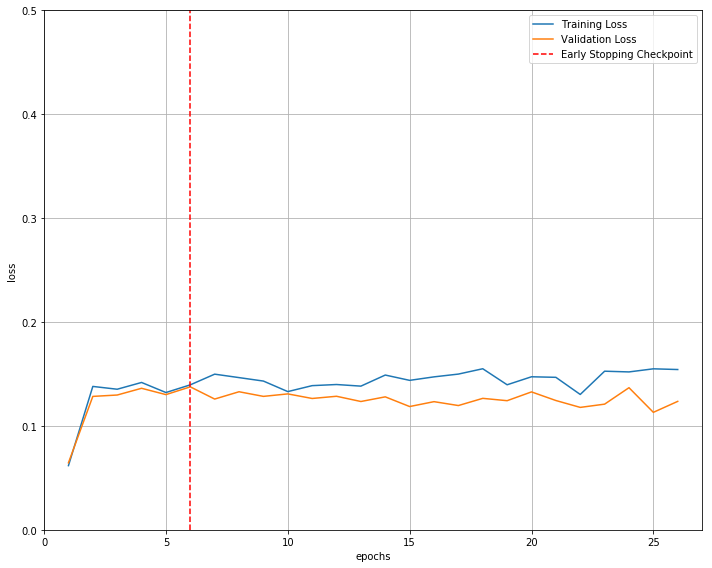

In [66]:
visualizeAndSave(train_loss, valid_loss, figName='')